# Imports

Standard Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import warnings
from pprint import pprint

LDA Imports

In [3]:
import gensim
import spacy
import nltk; # nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

SKLEARN - Supervised Training Imports

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score

Visualisation Imports

In [5]:
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
import matplotlib.pyplot as plt

Hypothesis Testing Imports

In [141]:
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

# Gather Data & Do Pre-Analysis

Import Training Data (from pickle file in this instance)

In [30]:
with open('../data/rev_train.pkl', 'rb') as f:
    rev_train = pickle.load(f)

rev_train['text_len'] = rev_train['text'].apply(lambda x: len(x.split())) # Add a column that displays text length
rev_train = rev_train.reset_index()

Review length vs sentiment (bad/good : 0/1)

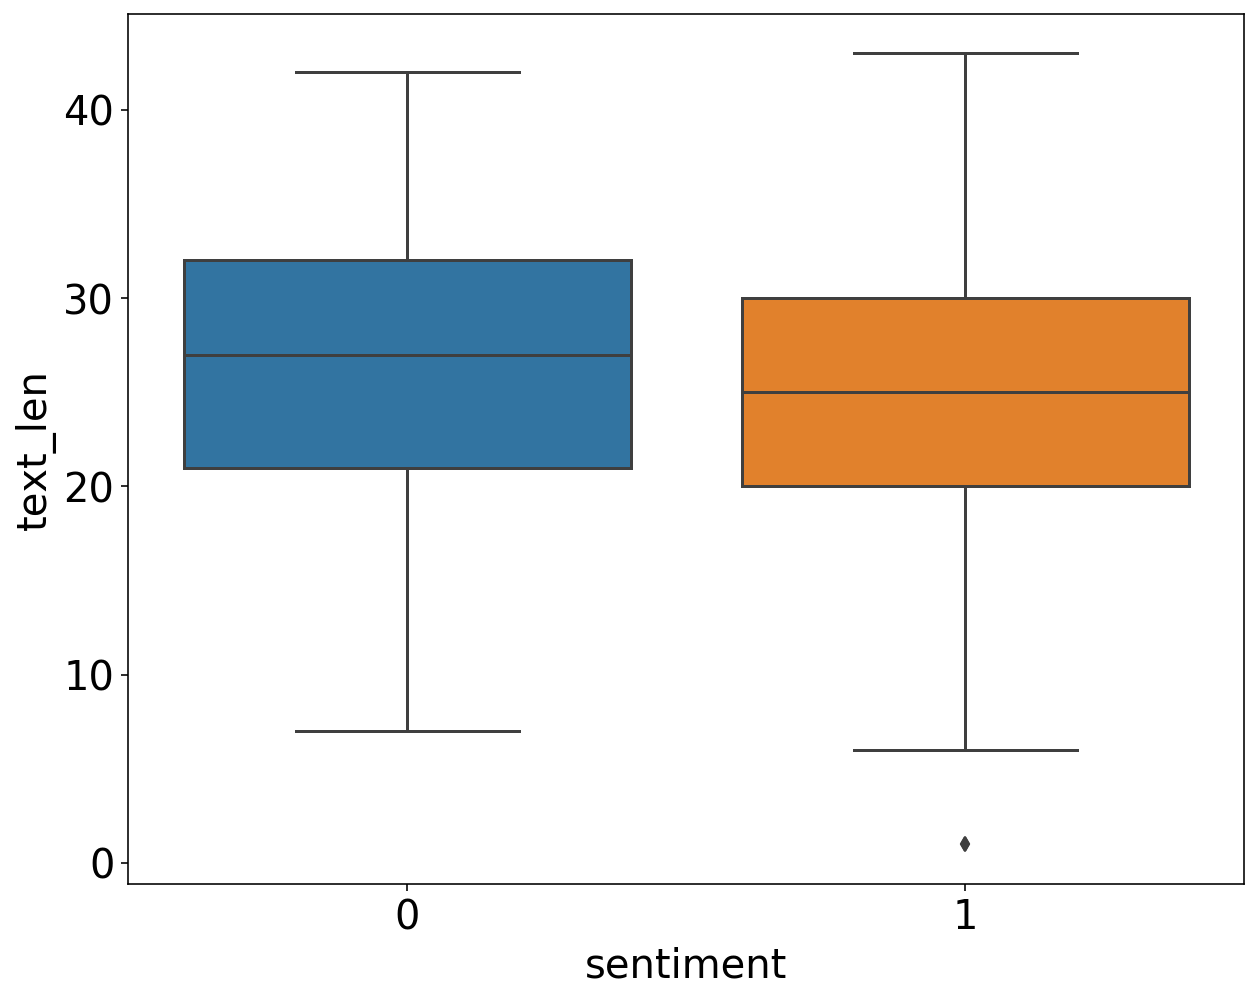

In [113]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size' : 20})
sns.boxplot(x = 'sentiment', y = 'text_len', data = rev_train.head(10000))

Number of reviews vs sentiment

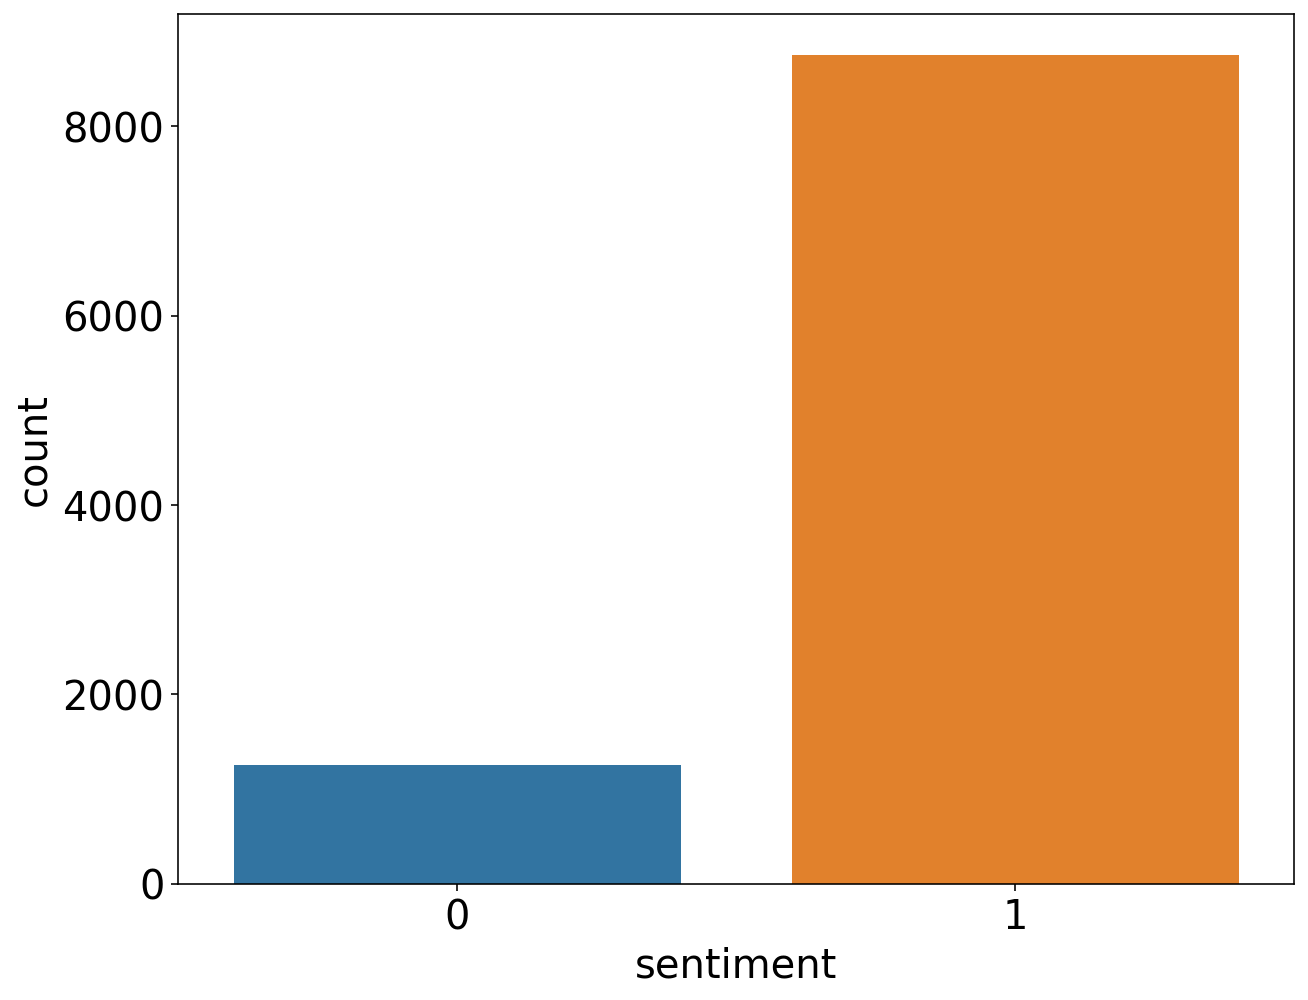

In [114]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot('sentiment', data = rev_train.head(10000))

Gensim LDA standard pre-process

In [85]:
# Edit these dependent upon your pre analysis of the data
stop_extra = ['come','order','try','go','get','make','drink','plate','dish','restaurant','place',
                  'would','really','like','great','service','came','got']

# Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(stop_extra)

# Spacy for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

# Regex strip all documents
def RegStrip(documents, reg, rep):
    return [re.sub(reg, rep, document) for document in documents]

# Tokenise and remove stopwords
def DocToWords(documents):
    output = []
    for doc in documents:
        x = simple_preprocess(str(doc), deacc=True)
        output.append([word for word in x if word not in stop_words])  
    return output

# Generate bi/trigram models 
def BigramModel(tokens, bi_min=15):
    
    bigram = gensim.models.Phrases(tokens, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    return bigram_mod

# Lemmatise documents
def Lemmatise(documents, allowed_posttags=['NOUN', 'ADV']):
    docs_out = []
    for doc in documents:
        doc_whole = nlp(" ".join(doc))
        docs_out.append([token.lemma_ for token in doc_whole if token.pos_ in allowed_posttags])
    return docs_out

# Generate a full corpus, with bi/trigrams, id2word mapping and document BOW vectors using the above standard functions
def GetCorpus(df):
    df['text'] = RegStrip(df.text, '\n', '')
    words = DocToWords(df.text)
    bigram = BigramModel(words)
    bigram = [bigram[text] for text in words]
    lemma = Lemmatise(bigram, allowed_posttags=['NOUN', 'ADV'])
    id2word = gensim.corpora.Dictionary(lemma)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in lemma]
    
    return corpus, id2word, lemma
    
    

In [93]:
# Using small slice of total data for brevity
data = rev_train.head(10000)
corpus_train, id2word_train, tokens_train = GetCorpus(data)

c:\python37\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


LDA training function

In [95]:
def TrainLda(corpus, id2word, k, alpha='symmetric', eta=None, chunk=100, passes=10):
    lda = gensim.models.ldamulticore.LdaMulticore(
                                            corpus=corpus,
                                            num_topics=k,
                                            id2word=id2word,
                                            chunksize=chunk,
                                            passes=passes,
                                            alpha=alpha,
                                            eta=eta,
                                            workers=3,
                                            eval_every=1,
                                            per_word_topics=True)
    return lda

def GetCoherence(lda, bow, id2word):
    coherence_model_lda = CoherenceModel(model=lda, texts=bow, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train_model = TrainLda(corpus_train, id2word_train, 20)

cv = GetCoherence(lda_train_model, tokens_train, id2word_train)

print(cv)
lda_train_model.print_topics(20, num_words=10)[:10]

0.5543896546025335


[(0,
  '0.322*"price" + 0.118*"selection" + 0.073*"staff_friendly" + 0.065*"style" + 0.051*"ambiance" + 0.042*"chef" + 0.040*"line" + 0.031*"check" + 0.030*"birthday" + 0.027*"beer"'),
 (1,
  '0.479*"love" + 0.195*"lunch" + 0.146*"people" + 0.025*"tea" + 0.018*"brunch" + 0.017*"level" + 0.015*"combination" + 0.015*"other" + 0.014*"mom" + 0.013*"ton"'),
 (2,
  '0.262*"also" + 0.093*"especially" + 0.076*"bread" + 0.054*"music" + 0.050*"every_time" + 0.042*"highly_recommend" + 0.031*"ambience" + 0.031*"recommendation" + 0.029*"reservation" + 0.027*"seafood"'),
 (3,
  '0.188*"quality" + 0.107*"option" + 0.105*"delivery" + 0.059*"roll" + 0.056*"dining" + 0.038*"water" + 0.030*"name" + 0.029*"piece" + 0.025*"ice" + 0.024*"later"'),
 (4,
  '0.185*"ever" + 0.077*"coffee" + 0.069*"dish" + 0.065*"minute" + 0.061*"recommend" + 0.054*"beef" + 0.053*"fast" + 0.052*"hour" + 0.043*"dessert" + 0.033*"job"'),
 (5,
  '0.134*"experience" + 0.081*"drink" + 0.073*"soup" + 0.058*"guy" + 0.056*"wait" + 0.052

# Training Classification Algorithms

We need to generate 'training vectors' which are just the topic probability values for each document.

In [131]:
def GetTrainingVecs(data, lda, corpus):
    vecs = []
    for i in range(len(data)):
        topics = lda.get_document_topics(corpus[i], minimum_probability=0.0)
        t_vec = [topics[i][1] for i in range(lda.num_topics)] # topic dist
        t_vec.extend([data.iloc[i].counts]) # no of docs refering to single resturant
        t_vec.extend([len(data.iloc[i].text)]) # length of doc
        vecs.append(t_vec)
    return vecs

train_vecs = GetTrainingVecs(data, lda_train_model, corpus_train)

We now have a series of training vectors, which give the topic distribution. We also know whether a review is good or bad (using the sentiment).

Therefore, we can now use this to run some supervised learning algorithms and generate a classifier which we can then apply to the test data.

In [132]:
X = np.array(train_vecs)
y = np.array(data.sentiment)

kf = KFold(5, shuffle=True, random_state=42)
lr_f1, sgd_f1 = [], []

# KFold training takes your data and splits k data sets.
# it then uses each small data set as test data and trains the models on the remaining k-1 sets
# It then measures the accuracy of the model by repeating this process multiple times
for train_ind, val_ind in kf.split(X, y):
    # n_splits is set to 5
    # assign the taining and test sets
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)
    
    #Logistic Regression
    lr = LogisticRegression(
        class_weight='balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)
    # GIven the model just trained, generate predictions, calculate accuracy value (f1) and add to list
    y_pred = lr.predict(X_val_scale)
    lr_f1.append(f1_score(y_val, y_pred, average='binary'))

    # SGD Huber
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    sgd_f1.append(f1_score(y_val, y_pred, average='binary')) 
    
    
print(f'Logistic Regression Val f1: {np.mean(lr_f1):.3f} +- {np.std(lr_f1):.3f}')
print(f'SGD Huber f1: {np.mean(sgd_f1):.3f} +- {np.std(sgd_f1):.3f}')
    

Logistic Regression Val f1: 0.756 +- 0.009
SGD Huber f1: 0.746 +- 0.373


# Using LDA and Classifier on Test Data

Load in test data and process, to generate corpus, id2word and tokens. 

In [133]:
with open('../data/rev_test.pkl', 'rb') as f:
    rev_test = pickle.load(f)
    
rev_test['text_len'] = rev_test['text'].apply(lambda x: len(x.split())) # Add a column that displays text length
rev_test = rev_train.reset_index()

data_test = rev_test.head(10000)
corpus_test, id2word_test, tokens_test = GetCorpus(data_test)

c:\python37\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We don't need the corpus/id2word as they are generated using the unseen data. We want to generate a corpus using the training id2word and the new tokens

In [134]:
corpus_test = [id2word_train.doc2bow(text) for text in tokens_test]

In [135]:
test_vecs = GetTrainingVecs(data_test, lda_train_model, corpus_test)

In [139]:
X = np.array(test_vecs)
y = np.array(data_test.sentiment)

ss = StandardScaler()
X = ss.fit_transform(X)

lr = LogisticRegression(
      class_weight= 'balanced',
      solver='newton-cg',
      fit_intercept=True
      ).fit(X, y)

y_lr = lr.predict(X)
print(f1_score(y, y_lr,average='binary'))

sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced',shuffle=True
    ).fit(X, y)

y_sgd = sgd.predict(X)
print(f1_score(y, y_sgd, average='binary'))


0.7578224883924366
0.93339021918831


In [147]:
X

array([[-0.44908393, -0.46835242, -0.4417868 , ..., -0.46841829,
        -0.61338839,  1.38943486],
       [-0.43622115, -0.4557737 , -0.42801768, ..., -0.45668287,
        -0.61338839,  0.91542825],
       [ 5.14634419, -0.27966818, -0.23524636, ..., -0.29238378,
        -0.61338839,  0.64879952],
       ...,
       [-0.39119694, -0.4117438 , -0.379821  , ..., -0.41560481,
        -0.73350189,  0.11554208],
       [-0.2561388 , -0.27966825, -0.23524645, ..., -0.29238385,
        -0.73350189,  1.21168238],
       [-0.3912    , -0.41174679, -0.37982428, ..., -0.4156076 ,
        -0.73350189, -0.06221041]])

# Testing LR vs SGD

In [144]:
y_true = y
y_m1 = y_lr
y_m2 = y_sgd

tb = mcnemar_table(y_target=y_true, y_model1=y_m1, y_model2=y_m2)
print(tb)
chi2, p = mcnemar(ary=tb, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p)

[[5631 3120]
 [ 770  479]]
chi-squared: 1418.4578406169667
p-value: 2.04889505015343e-310


The p-value is significantly small, therefore we can reject the hypothesis that both the models are equal.

The SGD model outperforms LR